<a href="https://colab.research.google.com/github/lnregmi/Transfer-Learning/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive #connecting google drive from google colab
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [1]:
#importing libraries from python
import os #operating system
import cv2 #opencv --> image related task
from PIL import Image # image related task
import numpy as np #mathematical calculation

In [ ]:
image_dir = "/content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/HIST/Dataset/" #path to import dataset
output_dir = "/content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/HIST/Model/" #path to save our model
image_shape = (64,64) #define the size 

In [ ]:
try: #k kaam try garne
  no_tumor_image_list = os.listdir(image_dir+'no/')
  tumor_image_list = os.listdir(image_dir+'yes/')

  print(("{:<25}"*2).format("Images with no tumor:",len(no_tumor_image_list))) #printing the number for no tumor list by couting the number of images
  print(("{:<25}"*2).format("Images with tumor:",len(tumor_image_list)))
  print(("{:<25}"*2).format("Total number of images: ",len(no_tumor_image_list)+len(tumor_image_list)))
except FileNotFoundError as fe: #try ma error ayo vane error handle garne
  print(fe) 

Images with no tumor:    1500                     
Images with tumor:       1500                     
Total number of images:  3000                     


# **Pre-Processing**
> **Only '.jpg' image**

> **Resize (64x64)**

> **Reflect (x-axis, y-axis, both-axis)**

> **Rotate (90deg, 270deg)**

In [ ]:
def img_read_and_resize(image_dir,folder,image_name): #defining the function "img_read_and_resize" --> parameter
  try:
    image = cv2.imread(image_dir+folder+image_name) #reads the images from the path
    image = Image.fromarray(image) #reads the image in array
    image = image.resize(image_shape) #convert the image into 64 * 64
    return image #return the value in image
  except Exception as e: #handling the error
    print(e)

def rotate_img(image,deg): #function
  if deg == 90: #syntax for if
    return image.transpose(Image.ROTATE_90) #rotating the image by 90 degree return
  elif deg == 270:
    return image.transpose(Image.ROTATE_270) #rotating the image by 270 and return

def reflect_img(image, axis):
  if axis == 0:
    return image.transpose(Image.FLIP_TOP_BOTTOM)
  elif axis == 1:
    return image.transpose(Image.FLIP_LEFT_RIGHT)
  elif axis == -1:
    x_ref = image.transpose(Image.FLIP_LEFT_RIGHT)
    return x_ref.transpose(Image.FLIP_TOP_BOTTOM)

def append_result(image,status,dataset,label):
  dataset.append(np.array(image)) #stacking
  label.append(status)
  #Rotate
  rot90 = rotate_img(image,90)
  dataset.append(np.array(rot90))
  label.append(status)
  rot270 = rotate_img(image,270)
  dataset.append(np.array(rot270))
  label.append(status)
  #Reflect
  x_ref = reflect_img(image,1)
  dataset.append(np.array(x_ref))
  label.append(status)
  y_ref = reflect_img(image,0)
  dataset.append(np.array(y_ref))
  label.append(status)
  b_ref = reflect_img(image,-1)
  dataset.append(np.array(b_ref))
  label.append(status)

def get_preprocessed_data(image_dir,no_tumor_image_list,tumor_image_list):
  dataset=[] #initialize the dataset naam gareko list 
  label=[] #initialize the label
  for image_name in no_tumor_image_list: #looping through out the folder to preprocess the image for no tumor
      if ".jpg" in image_name:
          image = img_read_and_resize(image_dir,'no/',image_name)
          append_result(image,0,dataset,label) #image, no tumor ko status, entire dataset, aile ko yes/no

  for image_name in tumor_image_list:
      if ".jpg" in image_name:
          image = img_read_and_resize(image_dir,'yes/',image_name)
          append_result(image,1,dataset,label)
  return dataset, label #returns the processed data 
            
dataset, label = get_preprocessed_data(image_dir,no_tumor_image_list,tumor_image_list) #function call garyo ani function le return gareko data lai receive garyo
dataset = np.array(dataset) #array ma convert
label = np.array(label) #array ma convert garyo

print(("{:<18}"*2).format("Total Dataset shape:",str(dataset.shape))) #string ma convert garyo --> dataset ko shape lai

Total Dataset shape:(18000, 64, 64, 3)


# Training, test and validation split

In [ ]:
#library import 
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split #80:20 


In [ ]:
def normalize(x, axis=1): #data normalization
  norm = np.linalg.norm(x, ord=2, axis=axis)  # ord=2 -> L2 Normalization
  l2 = np.atleast_1d(norm)
  l2[l2 == 0] = 1 #every element with value 0 to 1 .. else: NAN
  return x / np.expand_dims(l2, axis)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2) #x_train --> training data, y_train --> label
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5) #test data lai feri validation and test ma divide
x_train = normalize(x_train,axis=1) #train data lai mathi ko normalize function ma pass garera normalize gareko
x_test = normalize(x_test,axis=1)
x_val = normalize(x_val,axis=1)
y_train = np.array(y_train) #yo label ho, tumor xa ki nai vanera hereko, so normalize garnu parena
y_test = np.array(y_test)
y_val = np.array(y_val) #actual data ko label
 
print('Training Dataset shape:\t\t', x_train.shape) #train data ko shape lai print gareko
print('Training label size:\t\t', y_train.shape)
print('Validation Dataset shape:\t', x_val.shape)
print('Validation label size:\t\t', y_val.shape)
print('Testing Dataset shape:\t\t', x_test.shape)
print('Testing label size:\t\t', y_test.shape)


Training Dataset shape:		 (14400, 64, 64, 3)
Training label size:		 (14400,)
Validation Dataset shape:	 (1800, 64, 64, 3)
Validation label size:		 (1800,)
Testing Dataset shape:		 (1800, 64, 64, 3)
Testing label size:		 (1800,)


In [ ]:
#print(x_train)

In [ ]:
#print(y_train)

# CNN Model Building

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(image_shape[0],image_shape[1],3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

#model compile
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
#model ko summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_6 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                  

In [ ]:
history=model.fit(x_train,y_train,batch_size=16,validation_data=(x_test,y_test),epochs=10)
model.save(output_dir+"TumorModel10Epochs-128.h5")

Epoch 1/10
900/900 [==============================] - 5s 5ms/step - loss: 0.3622 - accuracy: 0.8422 - val_loss: 0.1727 - val_accuracy: 0.9383
Epoch 2/10
900/900 [==============================] - 5s 5ms/step - loss: 0.1172 - accuracy: 0.9635 - val_loss: 0.0618 - val_accuracy: 0.9806
Epoch 3/10
900/900 [==============================] - 5s 6ms/step - loss: 0.0592 - accuracy: 0.9831 - val_loss: 0.0471 - val_accuracy: 0.9856
Epoch 4/10
900/900 [==============================] - 4s 4ms/step - loss: 0.0424 - accuracy: 0.9874 - val_loss: 0.0410 - val_accuracy: 0.9906
Epoch 5/10
900/900 [==============================] - 4s 4ms/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.0574 - val_accuracy: 0.9867
Epoch 6/10
900/900 [==============================] - 4s 5ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.0482 - val_accuracy: 0.9889
Epoch 7/10
900/900 [==============================] - 4s 4ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.0505 - val_accuracy: 0.9889
Epoch 

In [ ]:
import tensorflow as tf
n=(output_dir+"TumorModel10Epochs-128.h5")
model = tf.keras.models.load_model(n)

In [ ]:
loss, acc = model.evaluate(x_val, y_val, batch_size= 16)
print('Test Accuracy:','%.5f'% acc)
print('Test Loss:', '%.5f'% loss)

113/113 [==============================] - 1s 3ms/step - loss: 0.0621 - accuracy: 0.9900
Test Accuracy: 0.99000
Test Loss: 0.06209


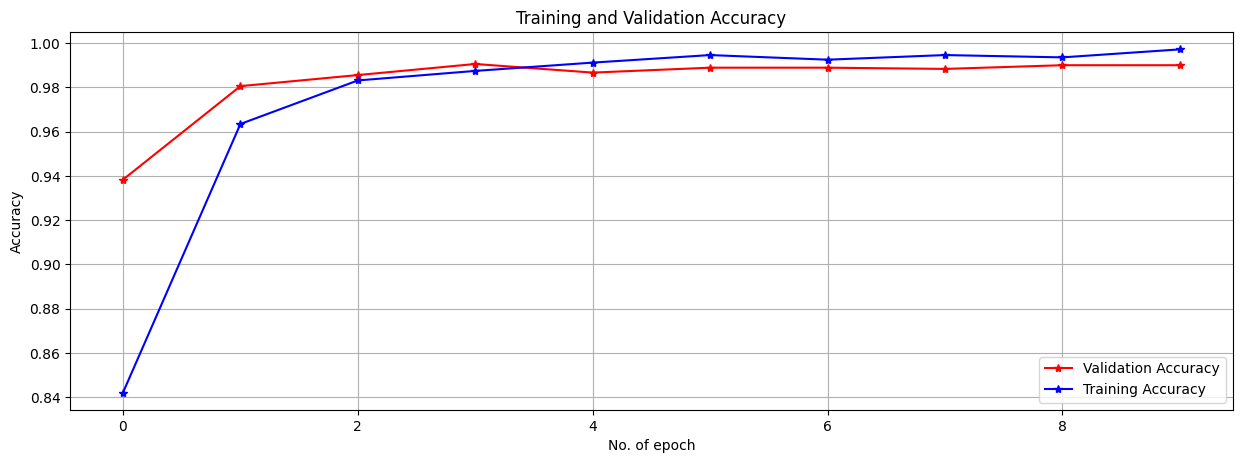

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
val_acc, = plt.plot(history.history['val_accuracy'],'r*-', label='Validation Accuracy')
acc, = plt.plot(history.history['accuracy'],'b*-', label='Training Accuracy')
plt.grid()
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of epoch')
plt.legend(handles=[val_acc, acc])
plt.show()

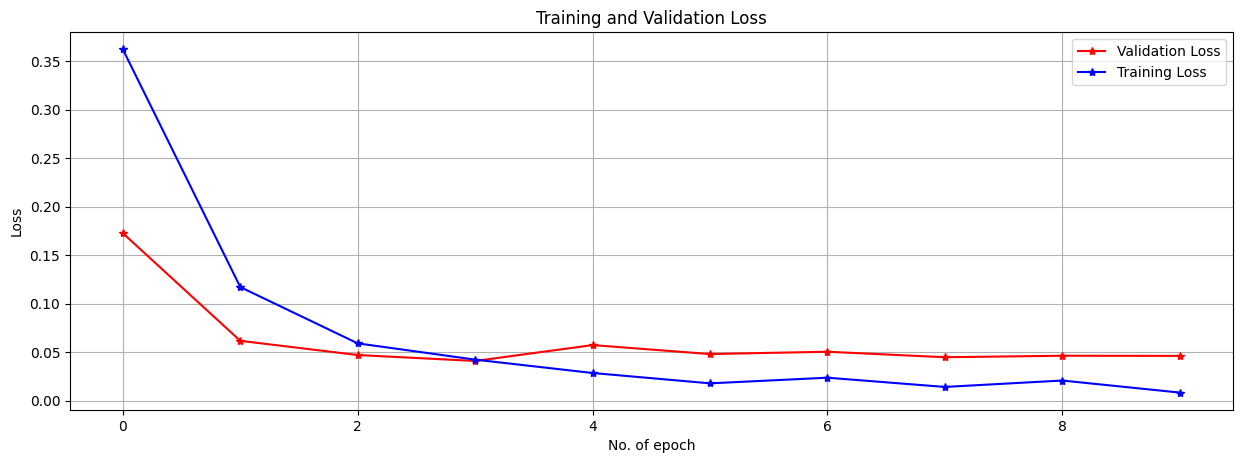

In [ ]:
plt.figure(figsize=(15, 5))
val_loss, = plt.plot(history.history['val_loss'],'r*-', label='Validation Loss')
loss, = plt.plot(history.history['loss'],'b*-', label='Training Loss')
plt.grid()
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('No. of epoch')
plt.legend(handles=[val_loss, loss])
plt.show()

In [ ]:
x_test_pred = model.predict(x=x_val,batch_size=16,verbose=1) #model ma validation data pathauda particular image lai 0/1 k vanxa, tyo sabai x_test_pred
x_test_pred[x_test_pred>=0.5] = 1
x_test_pred[x_test_pred<0.5] = 0 
#ava x_test_pred ma ki ta 0 auxa ki ta 1 auxa.
#for example
#y_val = [1,1,0.....1,0,0] --> image ma j xa tei ho
#x_test_pred =[1,1,1..........0,1,0] --> model le predict gareko

113/113 [==============================] - 0s 2ms/step


Accuracy on validation set:  0.99000


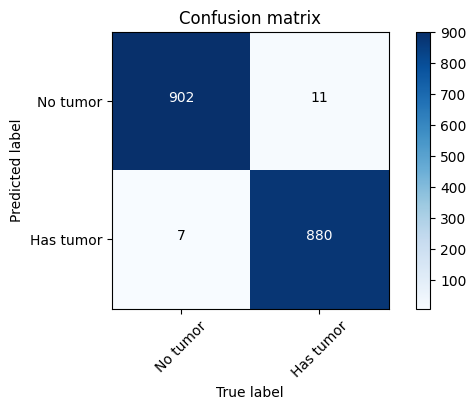

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix
import itertools
import matplotlib.pyplot as plt

cm=confusion_matrix(y_true=y_val,y_pred=x_test_pred)

def plot_confusion_matrix(cm, classes,cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    acc=(cm[0,0] + cm[1,1])/np.sum(cm)
    print("Accuracy on validation set: ", "%.5f"%acc)

cm_plot_labels = ['No tumor','Has tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

In [ ]:
print("="*20,"Classification Report","="*20,end="\n\n")
print(classification_report(y_val,x_test_pred))

==================== Classification Report ====================

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       913
           1       0.99      0.99      0.99       887

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



Cross Validation

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(output_dir+'BrainTumorModel-10FoldValidation.h5', verbose=1, save_best_only=True)
def fit_and_evaluate(train_x, test_x, train_y, test_y, EPOCHS=10, BATCH_SIZE=16):
    results = model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping, model_checkpoint],verbose=1, validation_split=0.1)  
    fold_loss, fold_acc= model.evaluate(test_x,test_y)
    print("Score:")
    print("Validation Loss:",fold_loss)
    print("Validation Accuracy:",fold_acc)
    return results

In [ ]:
n_folds=10
epochs=10
batch_size=32
history_cfold = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, random_state = np.random.randint(1,1000, 1)[0])
    history_cfold.append(fit_and_evaluate(train_x, test_x, train_y, test_y, epochs, batch_size))
    print("======="*10, end="\n\n\n")

Training on Fold:  1
Epoch 1/10
324/324 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9983
Epoch 1: val_loss improved from inf to 0.00187, saving model to /content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/HIST/Model/BrainTumorModel-10FoldValidation.h5
324/324 [==============================] - 4s 9ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0019 - val_accuracy: 0.9991
Epoch 2/10
324/324 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 2: val_loss improved from 0.00187 to 0.00036, saving model to /content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/HIST/Model/BrainTumorModel-10FoldValidation.h5
324/324 [==============================] - 2s 6ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 3.5965e-04 - val_accuracy: 1.0000
Epoch 3/10
317/324 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996
Epoch 3: val_loss improved from 0.00036 to 0.00005, saving model to

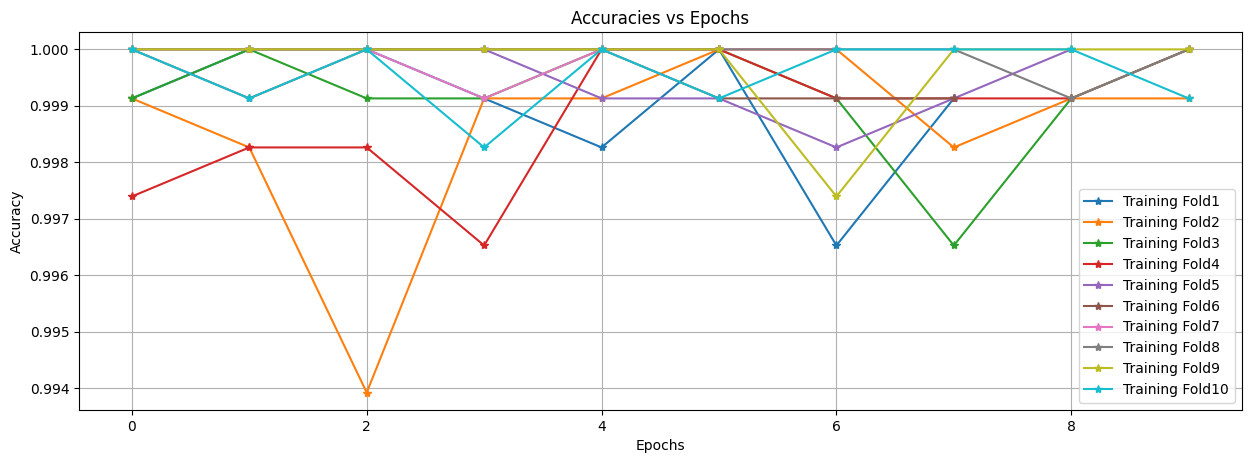

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Accuracies vs Epochs')
plt.grid()
for i in range(10):
  plt.plot(history_cfold[i].history['val_accuracy'],'*-', label=('Training Fold'+str(i+1)))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

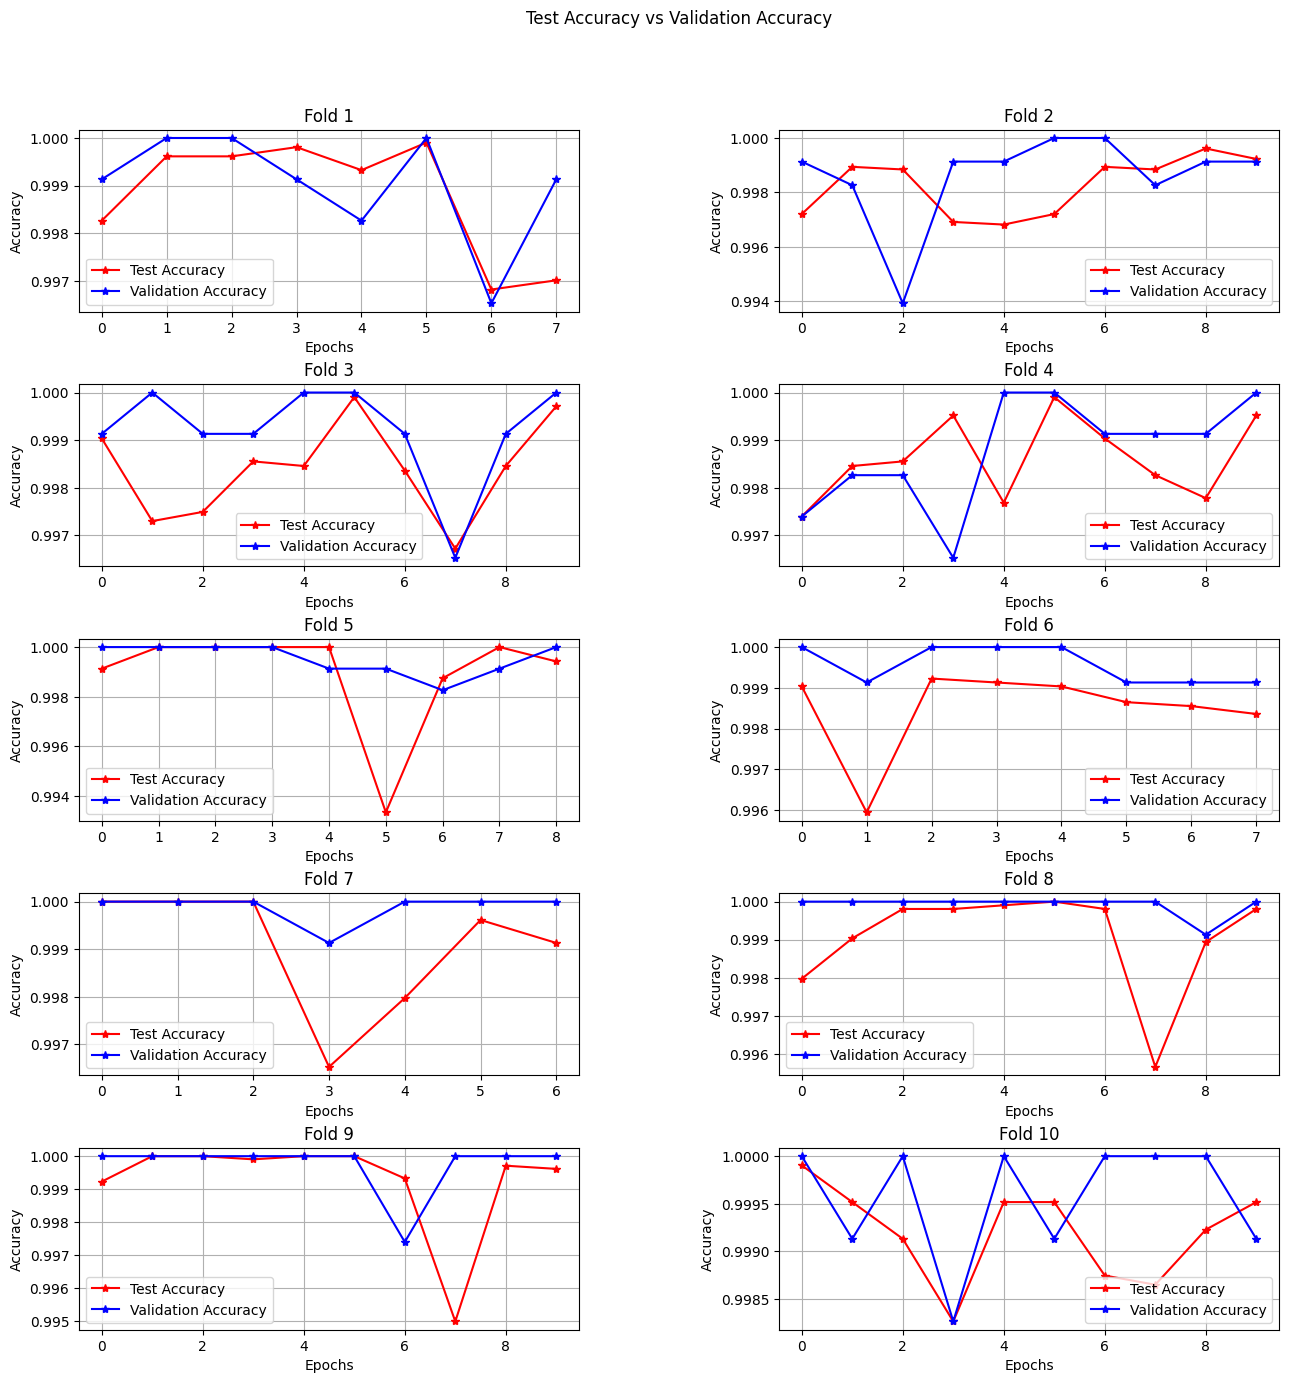

In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle("Test Accuracy vs Validation Accuracy")

for i in range(10):  
  plt.subplot(5,2,i+1,title=("Fold "+str(i+1)))     
  plt.grid()  
  plt.plot(history_cfold[i].history['accuracy'],'r*-', history_cfold[i].history['val_accuracy'],'b*-')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(['Test Accuracy', 'Validation Accuracy'])
  plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from keras.models import load_model
pre_model = load_model(output_dir+"BrainTumorModel-10FoldValidation.h5")
test_set_loss,test_set_acc = pre_model.evaluate(x_test,y_test)
val_set_loss,val_set_acc = pre_model.evaluate(x_val,y_val)
print("="*10,"Result","="*10)
print("Model Loss:",(test_set_loss+val_set_loss)/2)
print("Model Accuracy:",(test_set_acc+val_set_acc)/2)

57/57 [==============================] - 0s 4ms/step - loss: 0.0882 - accuracy: 0.9911
========== Result ==========
Model Loss: 0.070053206756711
Model Accuracy: 0.9913888871669769


In [ ]:
category=['tumor', 'no tumor']
image_number=5
single= np.expand_dims(x_test[image_number], axis=0)
pred_single=model.predict(single)
pred_single=np.argmax(pred_single, axis=-1)
category[pred_single[0]]

'tumor'

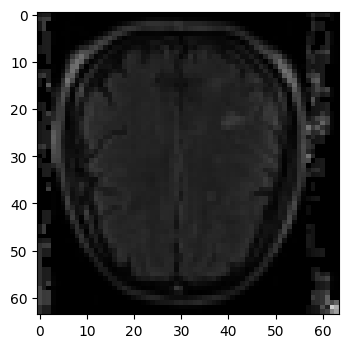

In [ ]:
plt.imshow(x_test[image_number])

In [ ]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)
    print(target_layer)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap

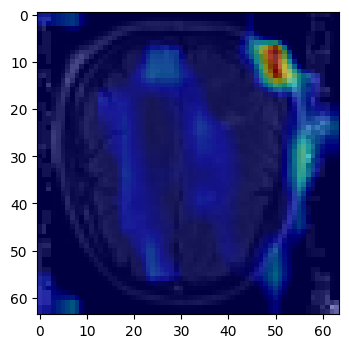

In [ ]:
plt.grid(False)
VizGradCAM(
    model,  #load model
    x_test[image_number]
)

Predict the real time image

In [ ]:
#importing libraries from python
import os #operating system
import cv2 #opencv --> image related task
from PIL import Image # image related task
import numpy as np #mathematical calculation

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
from keras.models import load_model
modelSaved = load_model('/content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/HIST/Model/BrainTumorModel-10FoldValidation.h5')

In [ ]:
# Testing on one image 
image = cv2.imread('/content/mydrive/My Drive/Research/Explainable AI For Brain Tumor/HIST/T.png') #tumor detected 
img = Image.fromarray(image)
img = img.resize((64,64))
img = np.array(img)

In [ ]:
input_img = np.expand_dims(img, axis=0)
result = modelSaved.predict(input_img)
print(result)

[[1.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


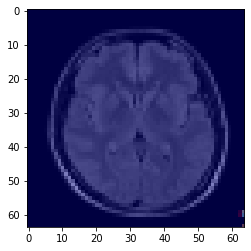

In [ ]:
plt.grid(False)
VizGradCAM(
    modelSaved,  #load model
    img
)